In [1]:
from glob import glob
model_feats = []
files = glob("./save_feature*")
for file in files:
    start = file.find("_model_")
    start_ = file[10:].find("_feature_")
    model_name = file[start:start_].split("_")[-1]
    feature_name = file[start_:-4].split("_")[-1]
    model_feats.append((model_name, feature_name.split(" + "), file))

In [2]:
import pandas as pd
g1 = pd.read_csv( '../traincorr1.csv', index_col=[0, 1, 2])
g2 = pd.read_csv( '../testcorr1.csv', index_col=[0, 1, 2])

g = pd.concat([g1, g2])

wb ="WHO"
feats = ['clusters', 'words', 'Meta', 'AppCats', 'RuLIWC']
indeces = [[0, 1], [0, 1], [0, 1, 2], [0, 1, 2], [0, 1, 2]]

appdata1 = pd.read_csv('../AppCatsBy3HoursNorm-1.csv', index_col=0)

data = {}

cldata = pd.read_csv( '../besth-clusters_' + wb + '.csv', index_col=[0, 1])
data['clusters'] = g.join(cldata)[cldata.columns]
data['AppCats'] = g.join(appdata1, lsuffix='mail')[appdata1.columns]

wdf1 = pd.read_csv('../RuLIWC-matrix-1year-traintest.csv', index_col=[0, 1, 2])
data['RuLIWC'] = g.join(wdf1, rsuffix='APP_')[wdf1.columns]

cols = g.dropna(axis=1).columns
cols = cols[2:]
cols = cols.drop(['MessNewest', 'MessOldest'])
data['Behavior'] = g[cols]

data['Words'] = pd.read_csv( '../words_selected.csv', index_col=[0, 1, 2])

In [3]:
import numpy as np
dfs = []
for m, feats, file in model_feats:
    features_with_weight = []
    with open(file) as f:
        parts = f.read().split("\t")
        for i in range(1, len(parts), 4):
            cv_n, masks, features, weights = parts[i: i+4]
            masks = [bool(int(i)) for i in list((masks.replace("\n", "").replace("  ", " ").replace("False", "0").replace("True", "1").strip())) if i in ["0", "1"]]
            features = eval(features)
            try:
                weights = eval(weights[:-3])
            except SyntaxError:
                weights = eval(weights)
            selected_features = []
            for i_mask, mask in enumerate(masks):
                if mask:
                    selected_features.append((m, int(cv_n), " ".join(feats), features[i_mask], float(weights[len(selected_features)])))
            features_with_weight.extend(selected_features)
    dfs.append(pd.DataFrame(np.array(features_with_weight ),
                   columns=['model_name', 'cv_n', 'feature_set', 'feature_name', "weight"]))
          

In [4]:
weights

[0.5407352766851046, 0.4592647233148954]

In [8]:
!mkdir tables_with_feature_importance

In [9]:
for df in dfs:
    df.to_csv(f"./tables_with_feature_importance/{df.model_name[0]}_{df.feature_set[0]}.csv")

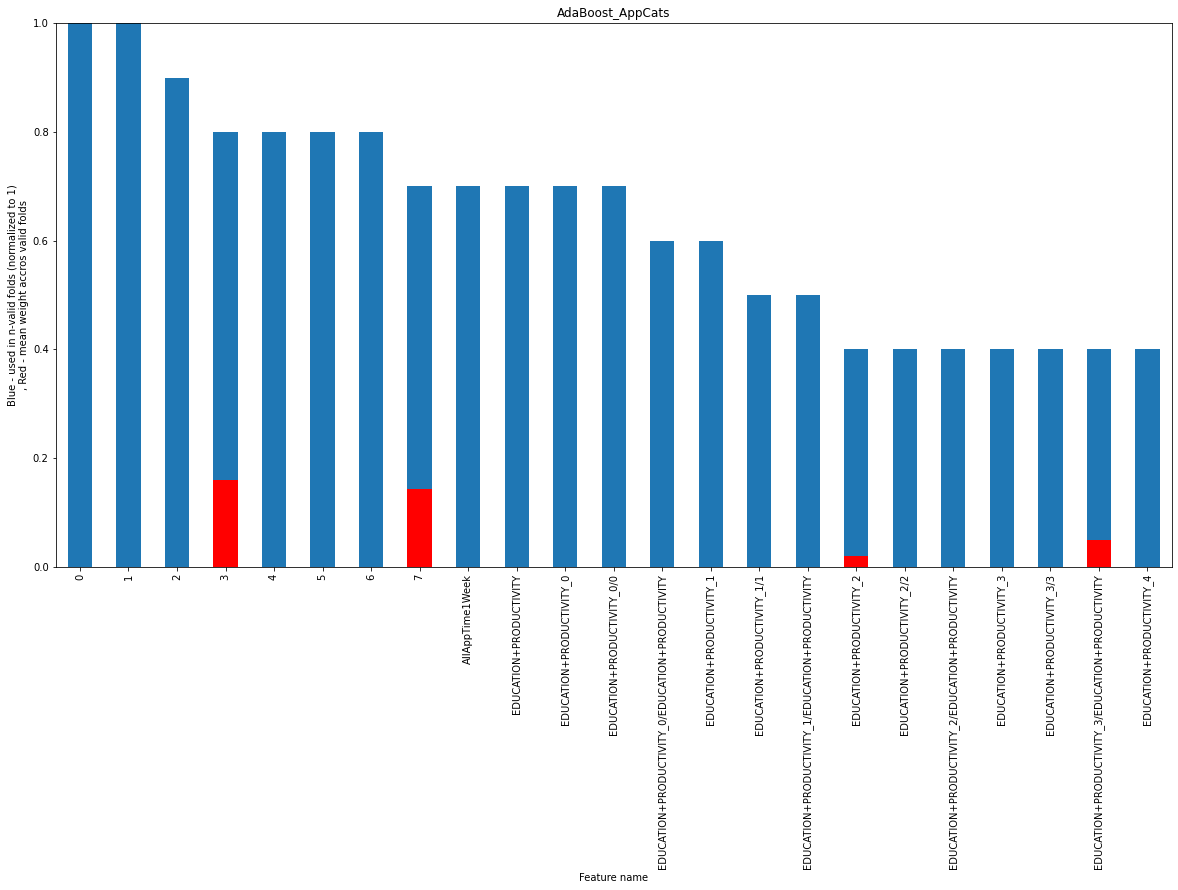

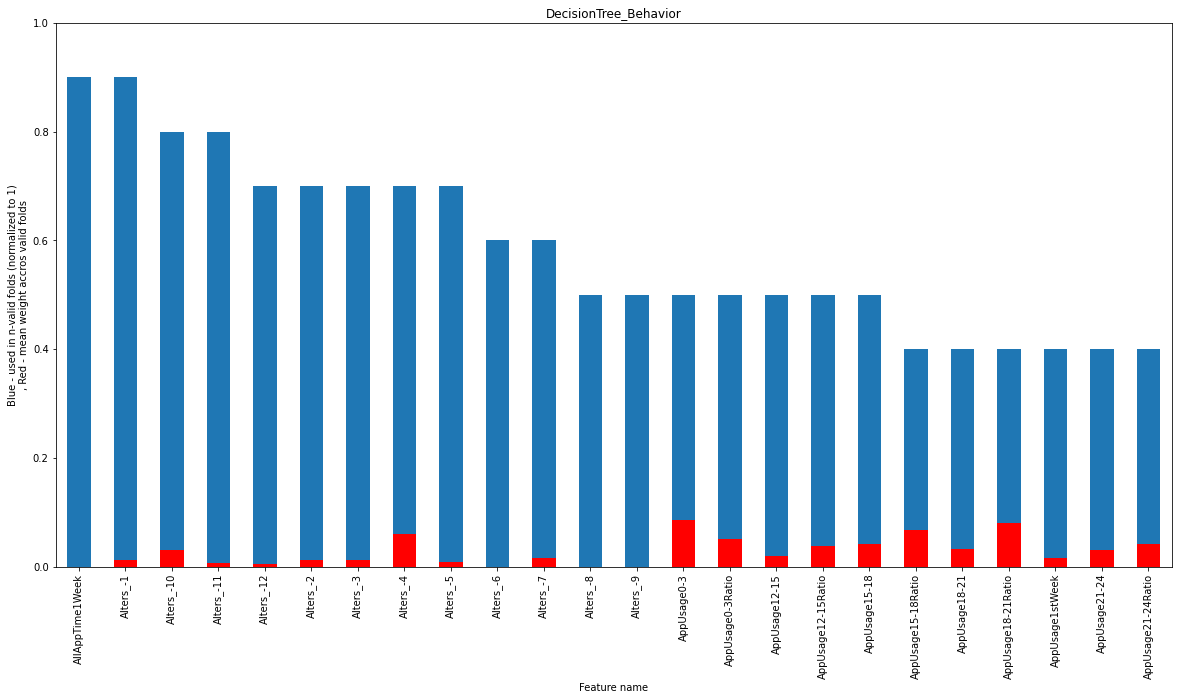

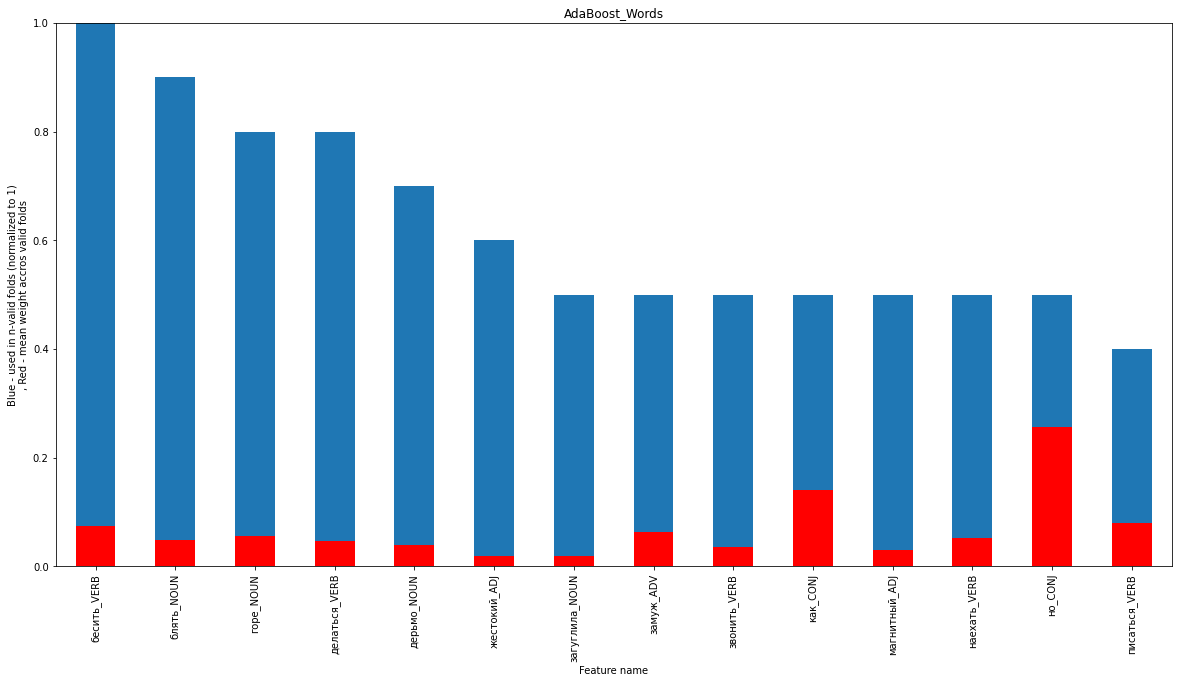

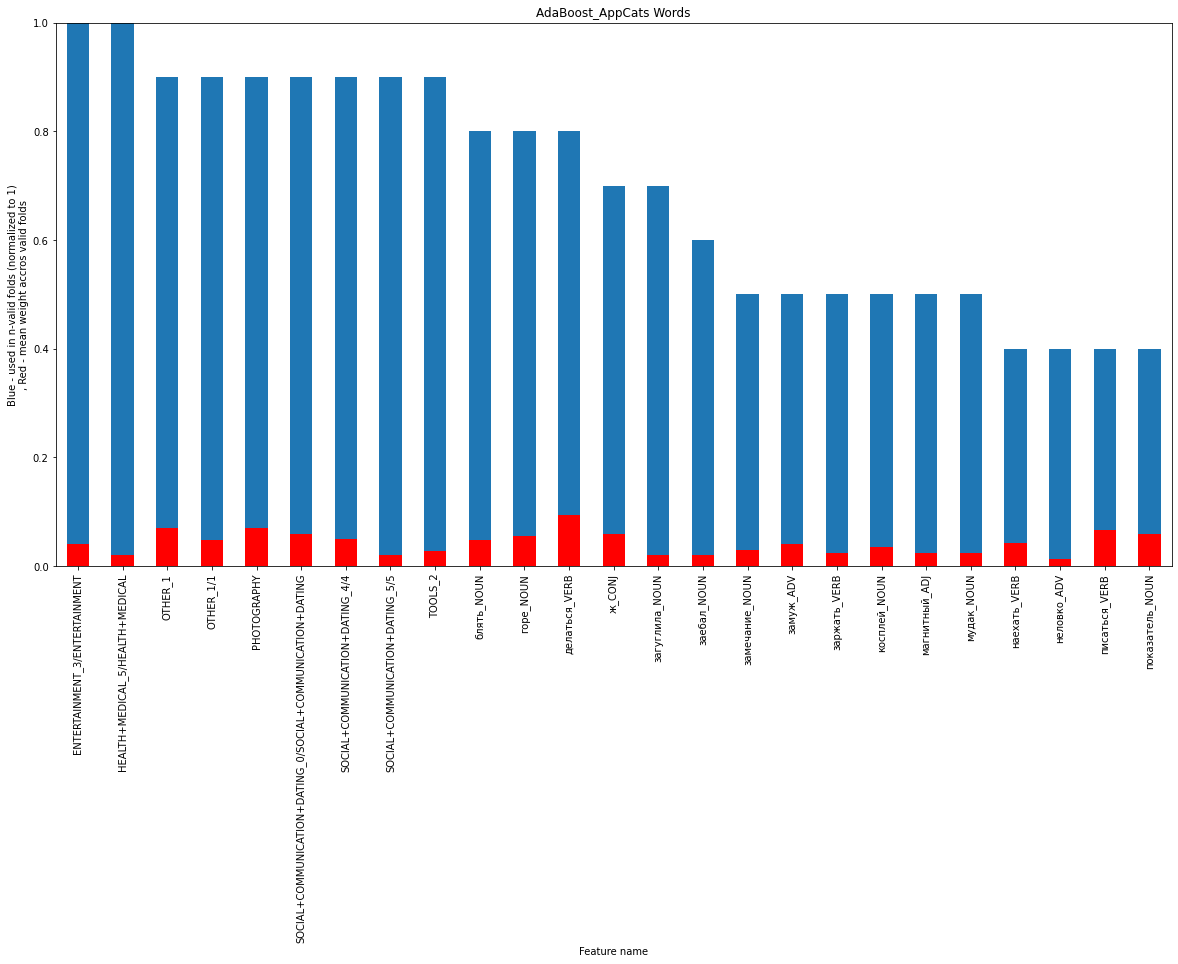

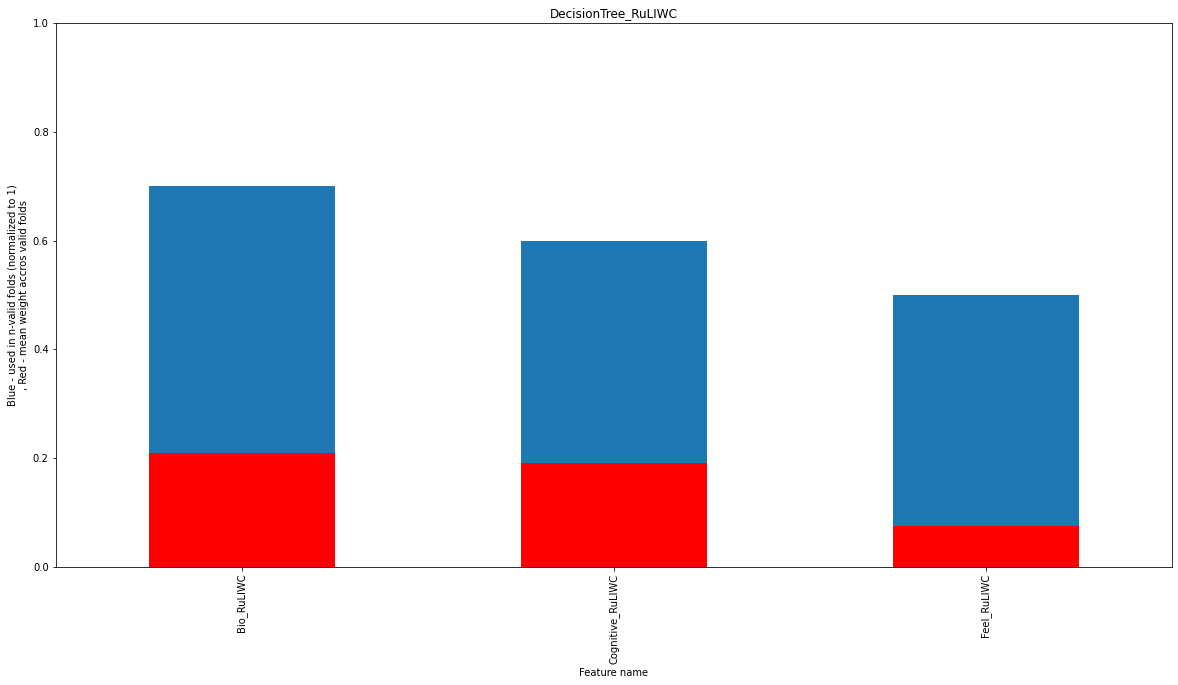

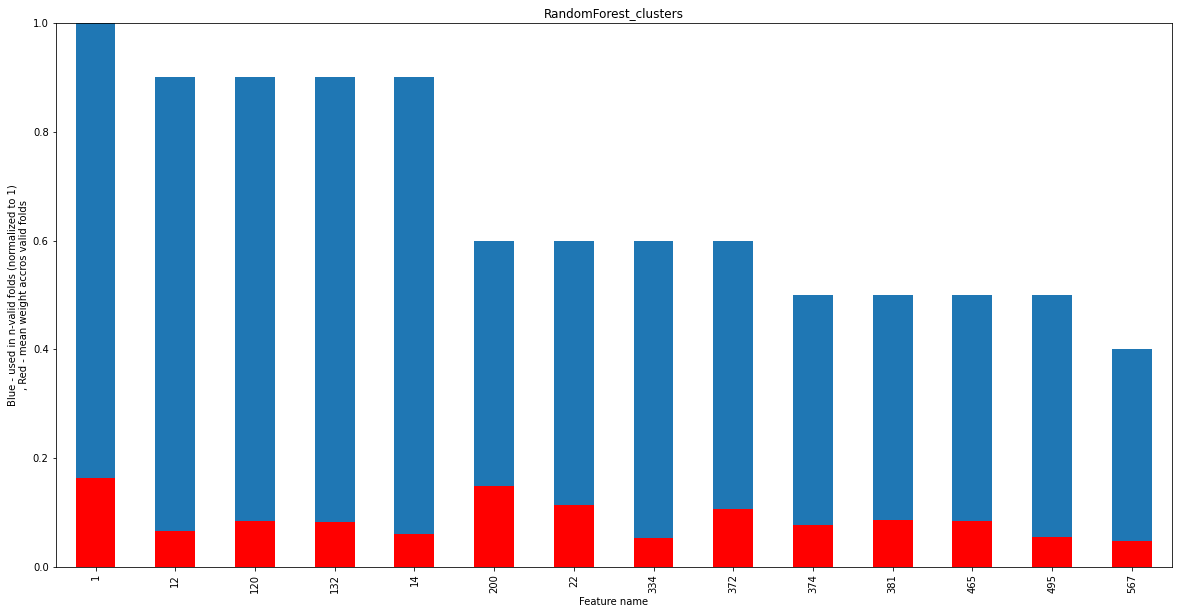

In [5]:
import matplotlib.pyplot as plt
for df in dfs:
    plt.figure(figsize=(20,10))
    plt.title(f"{df.model_name[0]}_{df.feature_set[0]}")
    most_common = df['feature_name'].value_counts()[df['feature_name'].value_counts()> 3]
    most_common.apply(lambda x:x/10).plot.bar()
    df["weight"] = df["weight"].astype(float)
    df[["feature_name", "weight"]].groupby("feature_name").weight.mean()[:most_common.shape[0]].plot.bar(color="red")
    plt.xlabel("Feature name")
    plt.ylabel("Blue - used in n-valid folds (normalized to 1)\n, Red - mean weight accros valid folds")
    plt.ylim((0,1))
    plt.show()